In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import numpy as np
import copy
import math
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
%matplotlib inline

# 1. Attribution & Allocation

In [4]:
sub_df = pd.read_csv('C:\\Users\\ZihanZ\\Desktop\\2022 Fall\\Marketing Analytics\\final project data\\Copy of subscribers.csv')

In [5]:
sub_df.head()

,Unnamed: 0,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,...,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,trial_completed
0,162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,...,NaN,ar,Standard Charter,14,True,1,2020-02-07 21:44:16,2020-06-07 21:44:16,NaN,True
1,380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,70.0,False,...,0.3303,ar,NaN,14,True,1,2020-03-15 15:44:35,2020-07-15 15:44:35,NaN,True
2,496617,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,...,0.1101,ar,NaN,14,False,0,NaN,NaN,NaN,True
3,356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,30.0,False,...,0.0367,ar,NaN,14,False,0,NaN,NaN,NaN,True
4,681701,26723159,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,...,0.0367,ar,NaN,14,True,2,2020-02-19 12:57:07,2020-06-19 12:57:07,NaN,True


In [10]:
num_conversion = sub_df.shape[0]
first_int = sub_df['attribution_survey'].value_counts()/num_conversion
last_int = sub_df['attribution_technical'].value_counts()/num_conversion
total_int = pd.concat([first_int, last_int], axis=1)
total_int.columns = ['first interact', 'last interact']
total_int1 = total_int.iloc[[0,3,8,23,24],:]
total_int1

,first interact,last interact
facebook,0.523336,0.352553
search,0.037306,0.111173
youtube,0.013654,0.004011
display,NaN,0.006181
bing,NaN,0.005035


Text(0.5, 1.0, 'Conversion Rate Breakdown')

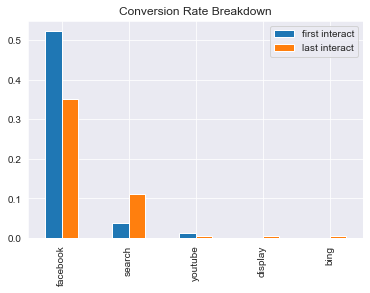

In [17]:
total_int1.plot.bar()
plt.title('Conversion Rate Breakdown')

In [12]:
channel_df = pd.read_csv('C:\\Users\\ZihanZ\\Desktop\\2022 Fall\\Marketing Analytics\\final project data\\Copy of channel_spend_graduate.csv')
channel_df.head()

,channel,date,spend_AED
0,bing,201907,400
1,display,201907,12
2,facebook,201907,9000
3,search,201907,13000
4,youtube,201907,90


## CAC using last interaction method

In [14]:
facebook = channel_df.loc[channel_df['channel']=='facebook']['spend_AED'].sum()/(total_int1.iloc[0,1] * num_conversion)
bing = channel_df.loc[channel_df['channel']=='bing']['spend_AED'].sum()/(total_int1.iloc[4,1] * num_conversion)
display = channel_df.loc[channel_df['channel']=='display']['spend_AED'].sum()/(total_int1.iloc[3,1] * num_conversion)
search = channel_df.loc[channel_df['channel']=='search']['spend_AED'].sum()/(total_int1.iloc[1,1] * num_conversion)
youtube = channel_df.loc[channel_df['channel']=='youtube']['spend_AED'].sum()/(total_int1.iloc[2,1] * num_conversion)

data = {'Channel': ['facebook','search','youtube','display','bing'],'CAC': [facebook,search,youtube,display,bing]}
data = pd.DataFrame(data)
data.set_index(['Channel'],inplace=True)
data

,CAC
Channel,
facebook,1.414313
search,8.792381
youtube,9.561884
display,0.260128
bing,9.424084


Text(0.5, 1.0, 'Channel CAC Breakdown')

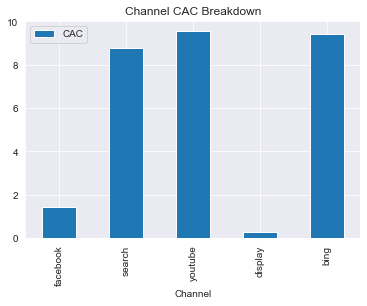

In [16]:
data.plot.bar()
plt.title('Channel CAC Breakdown')

# 2. Customer segmentation

In [18]:
new_sub = pd.DataFrame(sub_df, columns=['package_type','preferred_genre','intended_use','male_TF'])
new_sub.head()

,package_type,preferred_genre,intended_use,male_TF
0,economy,comedy,access to exclusive content,False
1,base,comedy,access to exclusive content,False
2,enhanced,regional,replace OTT,True
3,base,drama,replace OTT,False
4,base,comedy,replace OTT,False


In [21]:
# data cleaning
new_sub.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

,package_type,preferred_genre,intended_use,male_TF
0,economy,comedy,access to exclusive content,False
1,base,comedy,access to exclusive content,False
2,enhanced,regional,replace OTT,True
3,base,drama,replace OTT,False
4,base,comedy,replace OTT,False
...,...,...,...,...
227623,enhanced,comedy,supplement OTT,False
227624,enhanced,comedy,replace OTT,False
227625,base,comedy,access to exclusive content,False
227626,base,comedy,access to exclusive content,False


In [23]:
df_encoded = pd.get_dummies(data=new_sub, columns=['package_type','preferred_genre','intended_use','male_TF'], drop_first=True)
df_encoded.head()

,package_type_economy,package_type_enhanced,preferred_genre_drama,preferred_genre_international,preferred_genre_other,preferred_genre_regional,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,male_TF_True
0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,1,0,1
3,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0


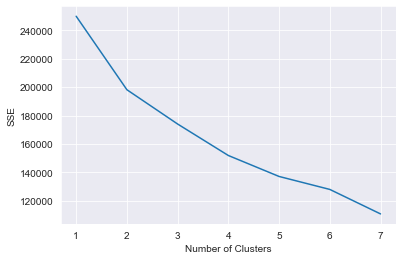

In [24]:
from sklearn.cluster import KMeans

kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

sse = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_encoded)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 8), sse)
plt.xticks(range(1, 8))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [34]:
kmeans = KMeans(init="random", n_clusters=3, n_init=10, random_state=1)
kmeans.fit(df_encoded)
kmeans.labels_

array([0, 0, 1, ..., 0, 0, 1])

In [35]:
new_sub['Clusters'] = kmeans.labels_
new_sub.head()

,package_type,preferred_genre,intended_use,male_TF,Clusters
0,economy,comedy,access to exclusive content,False,0
1,base,comedy,access to exclusive content,False,0
2,enhanced,regional,replace OTT,True,1
3,base,drama,replace OTT,False,2
4,base,comedy,replace OTT,False,1


Text(0.5, 1.0, 'Package Breakdown')

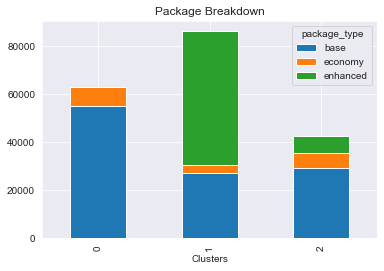

In [36]:
new_sub.groupby('Clusters')['package_type'].value_counts().unstack().plot.bar(stacked=True)
plt.title('Package Breakdown')

Text(0.5, 1.0, 'Preferred Genre Breakdown')

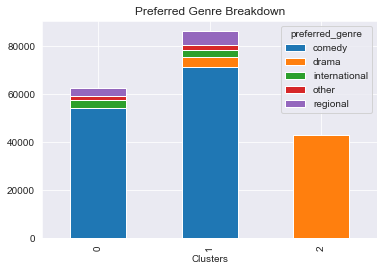

In [30]:
new_sub.groupby('Clusters')['preferred_genre'].value_counts().unstack().plot.bar(stacked=True)
plt.title('Preferred Genre Breakdown')

Text(0.5, 1.0, 'Intended Use Breakdown')

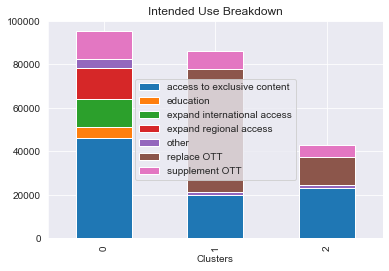

In [38]:
new_sub.groupby('Clusters')['intended_use'].value_counts().unstack().plot.bar(stacked=True).legend(loc='best')
plt.title('Intended Use Breakdown')

Text(0.5, 1.0, 'Gender Breakdown')

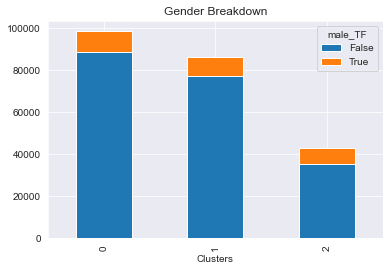

In [39]:
new_sub.groupby('Clusters')['male_TF'].value_counts().unstack().plot.bar(stacked=True)
plt.title('Gender Breakdown')